## Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.tokenize import TweetTokenizer
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

!pip install emoji
import emoji

## Carga y exploración del dataset

In [2]:
# df_train = pd.read_csv('train.csv')
# df_test = pd.read_csv('test.csv')
# df_valid = pd.read_csv('valid.csv')
# df = pd.concat([df_train, df_test, df_valid], ignore_index=True)
# df.drop("source", axis=1, inplace=True)

In [3]:
import xml.etree.ElementTree as ET
import requests
from io import StringIO
def cargar_tass_desde_url(url):
    """
    Carga el dataset TASS directamente desde una URL

    Args:
        url: URL del archivo XML de TASS

    Returns:
        DataFrame con los tweets procesados
    """
    # print(f"Descargando desde: {url}")

    # Descargar el contenido XML
    response = requests.get(url)
    response.encoding = 'utf-8'  # Importante para caracteres españoles

    if response.status_code != 200:
        raise Exception(f"Error al descargar: {response.status_code}")

    # Parsear el XML
    root = ET.fromstring(response.content)

    # Extraer datos
    tweets_data = []

    for tweet in root.findall('tweet'):
        # Extraer campos
        tweetid = tweet.find('tweetid').text if tweet.find('tweetid') is not None else ''
        user = tweet.find('user').text if tweet.find('user') is not None else ''
        content = tweet.find('content').text if tweet.find('content') is not None else ''
        date = tweet.find('date').text if tweet.find('date') is not None else ''
        lang = tweet.find('lang').text if tweet.find('lang') is not None else ''

        # Extraer sentimiento (puede estar anidado)
        sentiment_elem = tweet.find('sentiment/polarity/value')
        if sentiment_elem is None:
            sentiment_elem = tweet.find('.//value')  # Búsqueda más profunda

        sentiment = sentiment_elem.text if sentiment_elem is not None else 'NONE'

        tweets_data.append({
            'tweet_id': tweetid,
            'user': user,
            'text': content,
            'date': date,
            'lang': lang,
            'sentiment': sentiment
        })

    df = pd.DataFrame(tweets_data)
    # print(f"\nDataset cargado: {len(df)} tweets")
    # print(f"Distribución de sentimientos:\n{df['sentiment'].value_counts()}")

    return df

In [4]:
df1=cargar_tass_desde_url('http://tass.sepln.org/tass_data/dataset/intertass-ES-train-tagged.xml')
df2=cargar_tass_desde_url('http://tass.sepln.org/tass_data/dataset/TASS2019_country_MX_dev.xml')
df3=cargar_tass_desde_url('http://tass.sepln.org/tass_data/dataset/intertass-ES-development-tagged.xml')
df4=cargar_tass_desde_url('http://tass.sepln.org/tass_data/dataset/TASS2019_country_ES_train.xml')
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

In [5]:
df = df[df['text'].notna() & (df['text'] != '')]

# Normalizar etiquetas de sentimiento
# TASS usa: P (Positivo), N (Negativo), NEU (Neutral), NONE (Sin sentimiento)
mapeo_sentimientos = {
    'P': 'positive',
    'N': 'negative',
    'NEU': 'neutral',
    'NONE': 'none'
}

df['label'] = df['sentiment'].map(mapeo_sentimientos)

# Si quieres solo 3 clases (eliminar NONE)
df = df[df['label'] != 'none'].copy()

In [6]:
print(f"Dataset: \n{df.head(3)}")
print(f"\nShape: {df.shape}")
print(f"\nValores nulos: \n{df.isnull().sum()}")
print(f"\nCantiad de comentarios positivos: {df[df["label"] == "positive"].shape[0]}")
print(f"Cantiad de comentarios neutral: {df[df["label"] == "neutral"].shape[0]}")
print(f"Cantiad de comentarios negativos: {df[df["label"] == "negative"].shape[0]}")

Dataset: 
             tweet_id           user  \
1  768213567418036224       anahorxn   
2  768212591105703936   martitarey13   
3  768221670255493120  endlessmilerr   

                                                text                 date  \
1  @myendlesshazza a. que puto mal escribo\n\nb. ...  2016-08-23 22:29:21   
2  @estherct209 jajajaja la tuya y la d mucha gen...  2016-08-23 22:25:29   
3  Quiero mogollón a @AlbaBenito99 pero sobretodo...  2016-08-23 23:01:33   

  lang sentiment     label  
1   es         N  negative  
2   es         N  negative  
3   es         P  positive  

Shape: (2743, 7)

Valores nulos: 
tweet_id     0
user         0
text         0
date         0
lang         0
sentiment    0
label        0
dtype: int64

Cantiad de comentarios positivos: 987
Cantiad de comentarios neutral: 393
Cantiad de comentarios negativos: 1363


## Normailzación y limpieza del dataset

### Funciones

In [7]:
def emoji_a_texto(texto):
  texto_con_emoji = emoji.demojize(texto, delimiters=(" ", " "))
  return texto_con_emoji.lower()

def expandir_abreviaturas(texto):
    diccionario = {
        'tmb':'también',
        'tb':'también',
        'xq':'por qué',
        'pq':'porque',
        'pk':'porque',
        'q':'que',
        'd':'de',
        'k':'que',
        'xa':'para',
        'xo':'pero',
        'xl':'por el',
        'xfa':'por favor',
        'xf':'por favor',
        'pls':'por favor',
        'plz':'por favor',
        'dnd':'dónde',
        'dn':'de nada',
        'mñn':'mañana',
        'mñna':'mañana',
        'nph':'no puedo hablar',
        'nms':'no manches',
        'nmm':'no mames',
        'nmms':'no mames',
        'npn':'no pasa nada',
        'ntp':'no pasa nada',
        'as':'has',
        'bye':'adiós',
        'aki':'aquí',
        'rt':'retweet',
        'dm':'mensaje directo',
        'cc':'con copia',
        'yt':'YouTube',
        'ig':'Instagram',
        'fb':'Facebook',
        'tw':'Twitter',
        'tk':'TokTok',
        'lol':'reírse mucho',
        'lmao':'reírse mucho',
        'rofl':'revolcarse de risa',
        'omg':'oh dios mío',
        'wtf':'qué demonios',
        'f':'respetos',
        'rip':'descanse en paz',
        'gg':'buen juego',
        'wp':'bien jugado',
        'gl':'buena suerte',
        'hf':'diviértete',
        'salu2':'saludos',
        'x':'por',
        'sierto':'cierto',
        'alv':'a la verg',
        'smn':'si',
        'tqm':'te quiero mucho'
    }
    items_ordenados = sorted(diccionario.items(),
                           key=lambda x: len(x[0]),
                           reverse=True)
    for abrev, expansion in items_ordenados:
        patron = r'\b' + re.escape(abrev.strip()) + r'\b'
        texto = re.sub(patron, expansion.strip(), texto, flags=re.IGNORECASE)
    return texto

def limpieza_datos(tweet):
  texto = emoji_a_texto(tweet)
  texto = str(tweet).lower()
  # Normalizar repeticiones de caracteres
  texto = re.sub(r'(.)\1{2,}', r'\1\1', texto)
  # Normalización de jergas
  texto = expandir_abreviaturas(texto)
  # Sustitución de la tilde
  texto = texto.replace("á", "a")
  texto = texto.replace("é", "e")
  texto = texto.replace("í", "i")
  texto = texto.replace("ó", "o")
  texto = texto.replace("ú", "u")
  # Elimina numeros
  texto = re.sub(r'\d+', '', texto)
  # Elimina urls
  texto = re.sub(r'https?:///\S+|www\.\S+', '', texto)
  # Elimia los @
  texto = re.sub(r'@\w+', '', texto)
  # Elimina el #
  texto = texto.replace("#", "")
  # Normaliza los espacios
  texto = re.sub(r'\s+', ' ', texto)
  return texto

### Uso

In [8]:
df['texto_limpio'] = df['text'].apply(limpieza_datos)
for i in range(1, 5):
  if len(df['texto_limpio'][i]) != len(df['text'][i]):
    print(f"\nTexto original:\n {df['text'][i]}\nTexto limpio:\n {df['texto_limpio'][i]}")


Texto original:
 @myendlesshazza a. que puto mal escribo

b. me sigo surrando help 

3. ha quedado raro el "cómetelo" ahí JAJAJAJA
Texto limpio:
  a. que puto mal escribo b. me sigo surrando help . ha quedado raro el "cometelo" ahi jajajaja

Texto original:
 @estherct209 jajajaja la tuya y la d mucha gente seguro!! Pero yo no puedo sin mi melena me muero 
Texto limpio:
  jajajaja la tuya y la de mucha gente seguro!! pero yo no puedo sin mi melena me muero 

Texto original:
 Quiero mogollón a @AlbaBenito99 pero sobretodo por lo rápido que contesta a los wasaps 
Texto limpio:
 quiero mogollon a pero sobretodo por lo rapido que contesta a los wasaps 


## Tokenización

In [9]:
r = df.label.astype("category")
df["code"] = r.cat.codes
df.head(5)

,tweet_id,user,text,date,lang,sentiment,label,texto_limpio,code
1,768213567418036224,anahorxn,@myendlesshazza a. que puto mal escribo\n\nb. ...,2016-08-23 22:29:21,es,N,negative,a. que puto mal escribo b. me sigo surrando h...,0
2,768212591105703936,martitarey13,@estherct209 jajajaja la tuya y la d mucha gen...,2016-08-23 22:25:29,es,N,negative,jajajaja la tuya y la de mucha gente seguro!!...,0
3,768221670255493120,endlessmilerr,Quiero mogollón a @AlbaBenito99 pero sobretodo...,2016-08-23 23:01:33,es,P,positive,quiero mogollon a pero sobretodo por lo rapido...,2
4,768221021300264964,JunoWTFL,Vale he visto la tia bebiendose su regla y me ...,2016-08-23 22:58:58,es,N,negative,vale he visto la tia bebiendose su regla y me ...,0
5,768220253730009091,Alis_8496,@Yulian_Poe @guillermoterry1 Ah. mucho más por...,2016-08-23 22:55:55,es,P,positive,ah. mucho mas por supuesto! solo que lo inclu...,2


In [10]:
vectorizer_tf = TfidfVectorizer(
    ngram_range=(1, 3),
    max_features=7000,
    min_df=2,
    max_df=0.85,
    sublinear_tf=True,
    token_pattern=r'\b\w{2,}\b'
)

In [11]:
X_tfidf = vectorizer_tf.fit_transform(df['texto_limpio'])

In [12]:
print(f"\nDimensiones de la matriz TF-IDF: {X_tfidf.shape}")


Dimensiones de la matriz TF-IDF: (2743, 7000)


In [13]:
feature_names = vectorizer_tf.get_feature_names_out()
print(f"\nPrimeros 20 términos: {feature_names[:20]}")


Primeros 20 términos: ['aahm bueno' 'aahm bueno disfruta' 'abacos' 'abacos si' 'abacos si estan'
 'abajo' 'abajo esta' 'abajo esta jodido' 'abandonado' 'abandonado el'
 'abandonado el twitter' 'abandone' 'abandone el' 'abandone el pais'
 'abandone mi' 'abiertas' 'abierto' 'abrazarte' 'abrazo' 'absolutamente']


### Division de 80% entrenamiento y 20% pueba

In [14]:
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X_tfidf,
    df['code'],
    df.index,
    test_size=0.2,
    random_state=42,
    stratify=df['code']
)
print(f" X_train: {X_train.shape} texto (80%)")
print(f" X_test: {X_test.shape} texto (20%)")
print(f" y_train: {y_train.shape} etiquetas")
print(f" y_test: {y_test.shape} etiquetas")

 X_train: (2194, 7000) texto (80%)
 X_test: (549, 7000) texto (20%)
 y_train: (2194,) etiquetas
 y_test: (549,) etiquetas


## Entrenamiento

In [15]:
print("\nEntrenando modelo SVM...")
svm_model = svm.SVC(
    kernel='linear',     # Kernel lineal funciona bien con texto
    C=1.5,              # Parámetro de regularización
    random_state=42,
    class_weight='balanced'  # Balancea clases desbalanceadas
)

svm_model.fit(X_train, y_train)
print("Modelo entrenado exitosamente!")


Entrenando modelo SVM...
Modelo entrenado exitosamente!


## Pruebas


RESULTADOS DE EVALUACIÓN

Accuracy: 0.7486


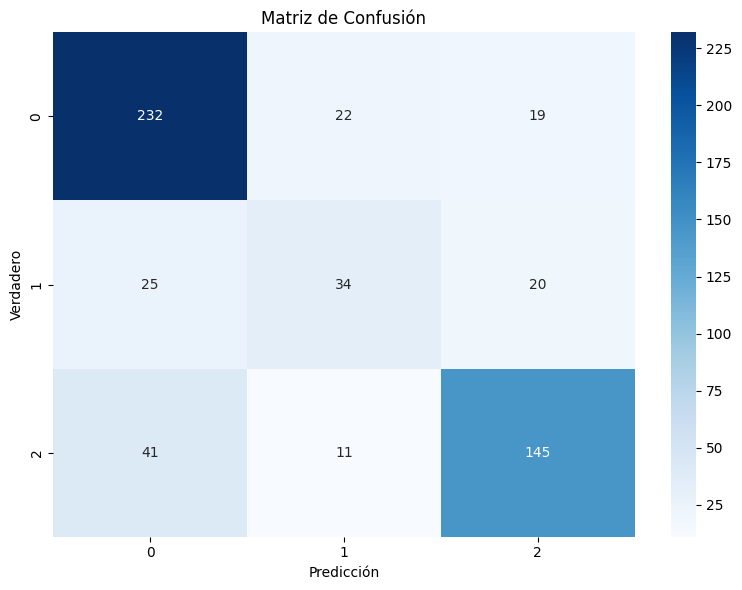

In [16]:
y_pred = svm_model.predict(X_test)

print("\n" + "="*50)
print("RESULTADOS DE EVALUACIÓN")
print("="*50)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=svm_model.classes_,
            yticklabels=svm_model.classes_)
plt.title('Matriz de Confusión')
plt.ylabel('Verdadero')
plt.xlabel('Predicción')
plt.tight_layout()
plt.show()

In [17]:
df_errores = df.loc[test_idx].copy()
df_errores['predicho'] = y_pred
df_errores['correcto'] = (y_test.values == y_pred)
neutros_mal = df_errores[(df_errores['code'] == 1) & (~df_errores['correcto'])]

print(f"Neutros mal clasificados: {len(neutros_mal)}")
print("\nEjemplos:")
for i, row in neutros_mal.head(5).iterrows():
    sentimiento = ['Negativo', 'Neutral', 'Positivo'][row['predicho']]
    print(f"\nTexto: {row['text']}")
    print(f"Limpio: {row['texto_limpio']}")
    print(f"Predicho como: {sentimiento}")

Neutros mal clasificados: 45

Ejemplos:

Texto: @_zylx jajaja que grosero! La dieta de la zona consiste en comer en la zona en la que andes
Limpio:  jajaja que grosero! la dieta de la zona consiste en comer en la zona en la que andes
Predicho como: Positivo

Texto: @bryantorresFSH @uby77 claro bryan es otra cuestión del tema ... Si abres más días alquiler más caro . 
Limpio:  claro bryan es otra cuestion del tema .. si abres mas dias alquiler mas caro . 
Predicho como: Positivo

Texto: Soy muy obvia pero me la suda 
Limpio: soy muy obvia pero me la suda 
Predicho como: Positivo

Texto: El bloqueo -en vez del mute- es en realidad una medida para reducir el ridículo para los que no saben que existe el screenshot 
Limpio: el bloqueo -en vez del mute- es en realidad una medida para reducir el ridiculo para los que no saben que existe el screenshot 
Predicho como: Negativo

Texto: Días!!! No trates de complacer a todos, no le temas al cambio, no vivas en el pasado, no te menosprecies, no pi

In [18]:
from sklearn.naive_bayes import MultinomialNB
modelo = MultinomialNB(alpha=0.1)
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)
accuracy = modelo.score(X_test, y_test)
print(accuracy)

0.7814207650273224


## Futuras pruebas

In [19]:
def predecir_sentimiento(texto):
    # Transformar el texto usando el vectorizador ya entrenado
    texto_vectorizado = vectorizer_tf.transform([texto])
    prediccion = svm_model.predict(texto_vectorizado)

    # Obtener probabilidades (requiere SVC con probability=True)
    # O usar decision_function para SVM lineal
    confianza = svm_model.decision_function(texto_vectorizado)

    return prediccion[0], confianza

In [20]:
print("\n" + "="*50)
print("PREDICCIONES DE EJEMPLO")
print("="*50)

ejemplo = [
    'Amo los gatos, son tan tiernos y esponjosoooosssss!!!!',
    '@user Que horrible le queda esa falda fea.',
    'No entiendo pq dices eso'
]
for texto in ejemplo:
    sentimiento, confianza = predecir_sentimiento(texto)
    print(f"\nTexto: '{texto}'")
    match sentimiento:
      case 0:
        print(f"Sentimienti: Negativo")
      case 1:
        print(f"Sentimienti: Neutro")
      case 2:
        print(f"Sentimienti: Positivo")
    print(f"Confianza: {confianza}")


PREDICCIONES DE EJEMPLO

Texto: 'Amo los gatos, son tan tiernos y esponjosoooosssss!!!!'
Sentimienti: Positivo
Confianza: [[ 1.02716664 -0.17980446  2.17326259]]

Texto: '@user Que horrible le queda esa falda fea.'
Sentimienti: Negativo
Confianza: [[ 2.22563773 -0.20878807  0.90161687]]

Texto: 'No entiendo pq dices eso'
Sentimienti: Neutro
Confianza: [[ 1.05208093  2.12152099 -0.14382043]]
